# Brain Games PCA based on STFT

In [15]:
%matplotlib inline
import numpy as np
import scipy.io
import sklearn
from sklearn.decomposition import PCA
import scipy.cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
import time

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

In [36]:
csvData = np.genfromtxt('1fileduplicatewithjawclench.csv', delimiter=',')

sample_time = 120
sample_len = csvData.shape[0]
window_len = 0.5 #how long is each window in terms of seconds
window_num = sample_time//window_len 
data_per_window = sample_len//(window_num) #data_per_window = datapoints per window = sample_len // (window_num)

assert(data_per_window % 2 == 0) #so it is easier for window num calculation since we are overlapping by half

print("There are",data_per_window, "datapoints per window, and there are", window_num, "windows.")

There are 112.0 datapoints per window, and there are 240.0 windows.


<Figure size 1152x648 with 0 Axes>

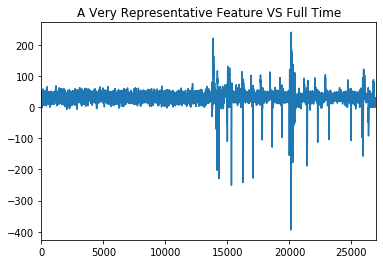

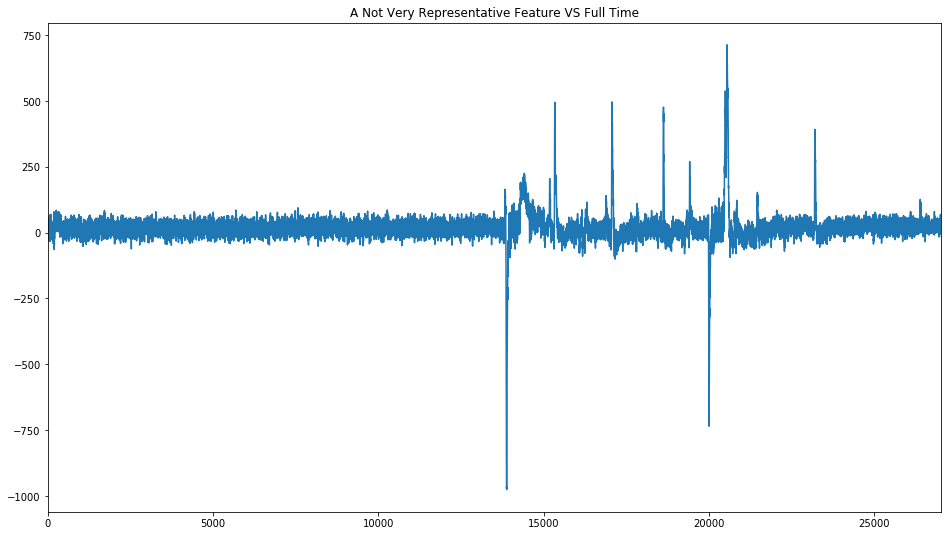

<Figure size 1152x648 with 0 Axes>

In [44]:
rawData = csvData[1:,4:5]
plt.plot(rawData[:,:])
plt.xlim((0,rawData.shape[0]))
plt.title('A Very Representative Feature VS Full Time')
plt.figure(figsize = (16,9))

rawData2 = csvData[1:,5:6]
plt.plot(rawData2[:,:])
plt.xlim((0,rawData2.shape[0]))
plt.title('A Not Very Representative Feature VS Full Time')
plt.figure(figsize = (16,9))

In [45]:
residual = sample_len % data_per_window
print("There are", residual, "points left out by segmentation, now cutting them from both ends...")
residualStart = residual // 2
residualEnd = residual - residualStart
residualEnd = -residualEnd+1 if residualEnd != 1 else len(rawData) #to cope with the wrapping around from the end

prunedData = rawData[residualStart : residualEnd,:]
assert prunedData.shape[0] % data_per_window == 0
print(prunedData.shape)

There are 9.0 points left out by segmentation, now cutting them from both ends...


TypeError: slice indices must be integers or None or have an __index__ method

483
There are 483 time window captured by STFT...


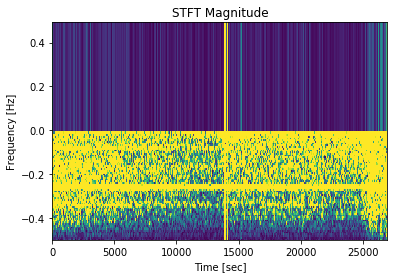

Parsing each DFT to extract the actual coefficients used in the trucated Fourier Series...


<Figure size 1152x648 with 0 Axes>

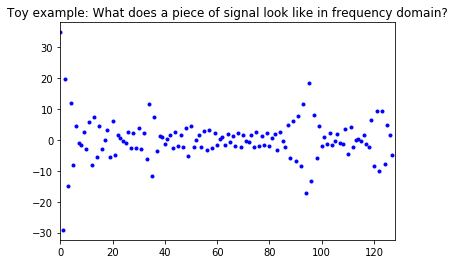

<Figure size 1152x648 with 0 Axes>

In [46]:
nfft = 128
f,t,Zxx = scipy.signal.stft(prunedData[:,0], nperseg=data_per_window, return_onesided=False, padded=False, nfft=nfft)
print(Zxx.shape[1])
#assert (Zxx.shape[1] == 2*window_num + 1)

print("There are", Zxx.shape[1],"time window captured by STFT...")
amp = 2 * np.sqrt(2)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


Zxx = Zxx.T #Zxx = new data matrix --> time windows are our new data points and frequency are the features
#We sacrificed segements of data to expand feature size from 1 to 256
#print(Zxx.shape)

print("Parsing each DFT to extract the actual coefficients used in the trucated Fourier Series...")
#print(Zxx[0])
for i in range(0,Zxx.shape[0]):
    chnl = Zxx[i]
    chnl[0] = chnl[0].real
    chnl[1:nfft//2] = 1*chnl[1:nfft//2].real
    chnl[nfft//2] = chnl[nfft//2]
    chnl[nfft//2 + 1:] = (1)*chnl[nfft//2 + 1:].imag
assert ((Zxx.real == Zxx).all())
#print("Coefficient extracted...")
Zxx = Zxx.real #The imaginary compoenent is 0 by now, we are just getting rid of the j for PCA
#Since PCA from sklearn doesn't handle complex data, let us simply use the weight of thecosine part of the frequency space


plt.plot(Zxx[0],'b.')
plt.title('Toy example: What does a piece of signal look like in frequency domain?')
plt.xlim((0,len(Zxx[0])))
plt.figure(figsize = (16,9))

In [51]:
"""segmentedData = [prunedData[i:i+data_per_window,:] for i in range(0, prunedData.shape[0] ,data_per_window)]
segmentedData = np.array(segmentedData)
assert segmentedData.shape[0] == window_num
assert segmentedData.shape[1] == data_per_window"""

pc_num = 3

print("Doing PCA analysis ...")
start_time = time.time()
pca = PCA(n_components = pc_num)
pca.fit(Zxx)
mean = pca.mean_
pc = pca.components_[:pc_num]
end_time = time.time()
print("Done!")
print("Duration: ", end_time - start_time)



Doing PCA analysis ...
Done!
Duration:  0.005510807037353516


<IPython.core.display.Javascript object>


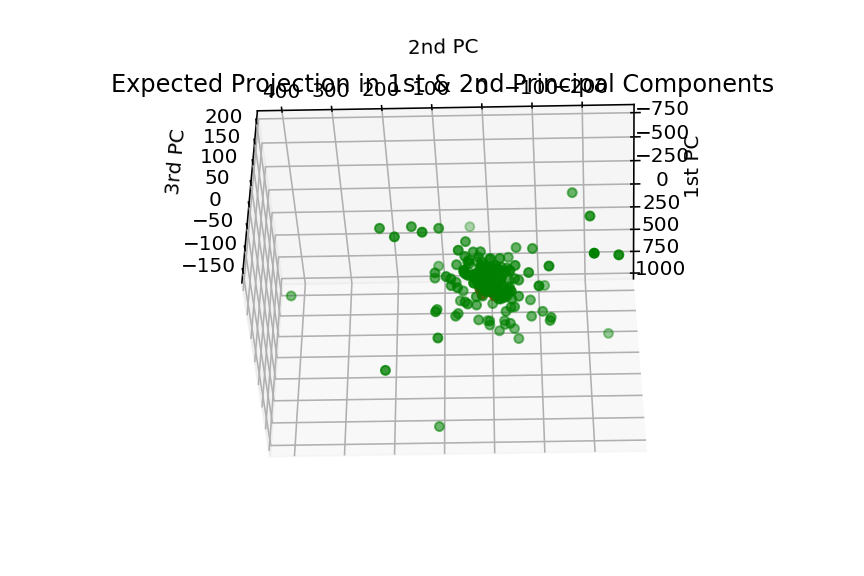

In [56]:
def PCA_project(data, new_basis, mean):
    #To see the data's repr in the basis of principal components
    return np.dot((data-mean), new_basis.T)
"""
plt.figure(figsize = (16,9))
proj = PCA_project(Zxx, pc, mean)
plt.scatter(*proj.T,s=50,c="r")
plt.title('Test Set Projection in 1st & 2nd Principal Components')
plt.figure()
plt.figure(figsize = (16,9))
projStatic = PCA_project(Zxx[0:Zxx.shape[0]//2,:], pc, mean)
plt.scatter(*projStatic.T,s=50,c="#87ceeb")
projDynamic = PCA_project(Zxx[Zxx.shape[0]//2:,:], pc, mean)
plt.scatter(*projDynamic.T,s=50,c="#ffa500")
plt.title('Expected Projection in 1st & 2nd Principal Components')
plt.figure()
"""
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
projEasy = PCA_project(Zxx[0:Zxx.shape[0]//2,:], pc, mean)
ax.scatter(projEasy[:,0], projEasy[:,1], projEasy[:,2], c='r', marker='o')

projMedium = PCA_project(Zxx[Zxx.shape[0]//2:,:], pc, mean)
ax.scatter(projMedium[:,0], projMedium[:,1], projMedium[:,2,], c='g', marker='o')

plt.title('Expected Projection in 1st & 2nd Principal Components')
plt.show()